# Predictive Analytics

In this course, we are working towards two types of "usage" for statistics and analytics:
1. We will see how to perform some statistical analyses for hypothesis testing using Python. This is similar to what you have been doing so far in other courses, and what you will most likely use for your thesis.
2. We will also see how to use statistics for **predictive analytics**, i.e., make predictions using digital trace data.

This notebook will briefly show what predictive analytics are, or at least how we execute one type of predictions using Python. *For now, all you need to do is follow the steps and understand the logic. By the end of the course, you will be able to perform this from beginning to end*.

**Don't worry about all the commands being used here. We will learn all of them in the coming weeks :-)**

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
import statsmodels.api as sm
%matplotlib inline

## The case
Our website has launched new campaigns to increase engagement with the website, and engagement being defined as ensuring that the user sees more pages (totals_pageviews) and does not leave the website upon entering through the campaign (landing_isExit, binary). It also wants to understand which of the campaigns leads to more sales (as binary, converted from totals_transactionRevenue) and revenue (totals_transactionRevenue).

# Loading data

Here we are loading and briefly inspecting the dataset. You will learn more about this in DA2 and DA3.

In [2]:
data = pd.read_csv('googlestore.csv')

/Users/theo/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data.head()

,channelGrouping,date,device_browser,device_deviceCategory,device_isMobile,device_operatingSystem,fullVisitorId,geoNetwork_city,geoNetwork_continent,geoNetwork_country,...,trafficSource_adwordsClickInfo_slot,trafficSource_campaign,trafficSource_isTrueDirect,trafficSource_keyword,trafficSource_medium,trafficSource_referralPath,trafficSource_source,visitId,visitNumber,visitStartTime
0,Referral,20171001,Chrome,desktop,False,Macintosh,9460190543836614586,NaN,Americas,United States,...,NaN,(not set),NaN,NaN,(none),/,(direct),1506841168,1,1506841201
1,Paid Search,20171001,Chrome,desktop,False,Macintosh,1480173241963500874,NaN,Americas,United States,...,Top,AW - Dynamic Search Ads Whole Site,NaN,6qEhsCssdK0z36ri,cpc,NaN,google,1506841096,1,1506841214
2,Display,20171001,Chrome,mobile,True,Android,2873420789599649821,NaN,Americas,United States,...,RHS,1000557 | GA | US | en | Hybrid | GDN Remarketing,NaN,(automatic matching),cpc,NaN,google,1506841239,1,1506841239
3,Display,20171001,Samsung Internet,mobile,True,Android,958777956895332252,Houston,Americas,United States,...,RHS,1000557 | GA | US | en | Hybrid | GDN Remarketing,NaN,(automatic matching),cpc,NaN,google,1506841255,1,1506841255
4,Display,20171001,Safari,mobile,True,iOS,3000721821736270436,Chicago,Americas,United States,...,RHS,1000557 | GA | US | en | Hybrid | GDN Remarketing,NaN,(automatic matching),cpc,NaN,google,1506841264,1,1506841264


In [4]:
data.columns

Index(['channelGrouping', 'date', 'device_browser', 'device_deviceCategory',
       'device_isMobile', 'device_operatingSystem', 'fullVisitorId',
       'geoNetwork_city', 'geoNetwork_continent', 'geoNetwork_country',
       'geoNetwork_metro', 'geoNetwork_networkDomain', 'geoNetwork_region',
       'geoNetwork_subContinent', 'landing_appInfo_landingScreenName',
       'landing_appInfo_screenDepth', 'landing_appInfo_screenName',
       'landing_contentGroup_contentGroup1',
       'landing_contentGroup_contentGroup2',
       'landing_contentGroup_contentGroup3',
       'landing_contentGroup_contentGroup4',
       'landing_contentGroup_contentGroup5', 'landing_hour',
       'landing_isEntrance', 'landing_isExit', 'landing_minute',
       'landing_page_hostname', 'landing_page_pagePath',
       'landing_page_pagePathLevel1', 'landing_page_pagePathLevel2',
       'landing_page_pagePathLevel3', 'landing_page_pagePathLevel4',
       'landing_page_pageTitle', 'landing_product_isClick',
      

In [5]:
data['trafficSource_medium'].value_counts()

organic      22781
cpc          13643
(none)        9363
referral      5506
affiliate      756
cpm            258
(not set)        1
Name: trafficSource_medium, dtype: int64

## Data cleaning

Here we are taking steps to prepare the variables that are important for the analysis. You will learn more about it in DA3.

In [6]:
data['landing_isExit'].value_counts()

True    30908
Name: landing_isExit, dtype: int64

In [7]:
def fix_landing(landing):
    if str(landing).lower() == 'nan':
        return 0
    return 1

In [8]:
data['isExit'] = data['landing_isExit'].apply(fix_landing)

In [9]:
data['isExit'].describe()

count    52308.000000
mean         0.590885
std          0.491675
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: isExit, dtype: float64

In [10]:
data['totals_pageviews'].describe()

count    52302.000000
mean         3.165615
std          6.322601
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max        500.000000
Name: totals_pageviews, dtype: float64

We want to understand if campaigns from affiliates or using cpc are performing better than other ways that visitors have to get to the site.

In [11]:
def check_category(source, variablename):
    if source == variablename:
        return 1
    return 0

In [12]:
data['cpc'] = data['trafficSource_medium'].apply(check_category, args=('cpc',))
data['affiliate'] = data['trafficSource_medium'].apply(check_category, args=('affiliate',))

In [13]:
data[['cpc', 'affiliate',]].describe()

,cpc,affiliate
count,52308.000000,52308.000000
mean,0.260821,0.014453
std,0.439086,0.119349
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,1.000000,1.000000


In [14]:
data[['totals_pageviews', 'cpc', 'affiliate', 'isExit']].isna().sum()

totals_pageviews    6
cpc                 0
affiliate           0
isExit              0
dtype: int64

In [15]:
data['pageviews'] = data['totals_pageviews'].fillna(0)

## Data exploration and visualisation

Here we are looking at the descriptive statistics of the final dataset and using visualisations to understand the relationship between variables. You will learn more about in DA4.

In [16]:
data[['cpc', 'affiliate', 'isExit', 'pageviews']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cpc,52308.0,0.260821,0.439086,0.0,0.0,0.0,1.0,1.0
affiliate,52308.0,0.014453,0.119349,0.0,0.0,0.0,0.0,1.0
isExit,52308.0,0.590885,0.491675,0.0,0.0,1.0,1.0,1.0
pageviews,52308.0,3.165252,6.322329,0.0,1.0,1.0,3.0,500.0


In [17]:
data[['cpc', 'affiliate', 'isExit', 'pageviews']].groupby(['cpc', 'affiliate']).describe().transpose()

cpc                         0                         1
affiliate                   0           1             0
isExit    count  37909.000000  756.000000  13643.000000
          mean       0.496689    0.579365      0.853258
          std        0.499996    0.493988      0.353861
          min        0.000000    0.000000      0.000000
          25%        0.000000    0.000000      1.000000
          50%        0.000000    1.000000      1.000000
          75%        1.000000    1.000000      1.000000
          max        1.000000    1.000000      1.000000
pageviews count  37909.000000  756.000000  13643.000000
          mean       3.757947    2.687831      1.544822
          std        7.126369    4.252982      2.743431
          min        0.000000    1.000000      0.000000
          25%        1.000000    1.000000      1.000000
          50%        2.000000    1.000000      1.000000
          75%        4.000000    3.000000      1.000000
          max      500.000000   51.000000    101.000000

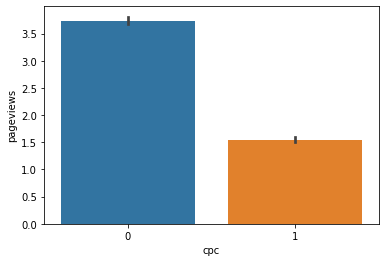

In [18]:
sns.barplot(x='cpc', y='pageviews', data=data)

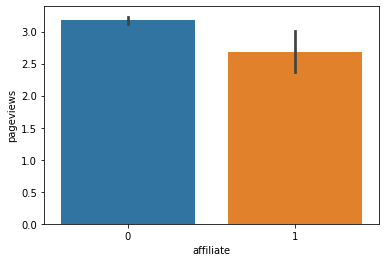

In [19]:
sns.barplot(x='affiliate', y='pageviews', data=data)

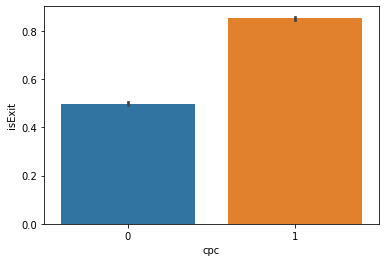

In [20]:
sns.barplot(x='cpc', y='isExit', data=data)

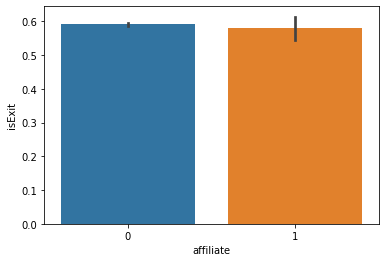

In [21]:
sns.barplot(x='affiliate', y='isExit', data=data)

## Modelling and hypothesis testing

Here we are using traditional statistics and machine learning to understand the differences between campaigns. You will learn more about in DA5 and DA6.

## Predictions for pageviews using Linear (OLS) regression

First, the "traditional" (frequentist) statistics.

In [22]:
ols_stat = sm.OLS(data['pageviews'], sm.add_constant(data[['cpc', 'affiliate']]))

/Users/theo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [23]:
result_ols = ols_stat.fit()

In [24]:
print(result_ols.summary())

                            OLS Regression Results                            
Dep. Variable:              pageviews   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     631.7
Date:                Mon, 20 Jan 2020   Prob (F-statistic):          8.08e-272
Time:                        14:23:49   Log-Likelihood:            -1.7006e+05
No. Observations:               52308   AIC:                         3.401e+05
Df Residuals:                   52305   BIC:                         3.401e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7579      0.032    117.117      0.0

### Now, using ML for predictive analytics.

In [25]:
ols_clf = LinearRegression(fit_intercept = True)

In [26]:
ols_clf.fit(data[['cpc', 'affiliate']], data['pageviews'])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [27]:
ols_clf.predict([[1,0]])

array([1.54482152])

In [28]:
ols_clf.predict([[0,1]])

array([2.68783069])

In [29]:
ols_clf.predict([[0,0]])

array([3.75794666])

## Probabilities for leaving the website using Logistic Regression

First, using "traditional" (frequentist) statistics. But for a **binary** dependent variable.

In [30]:
logit_stats = sm.Logit(data['isExit'], sm.add_constant(data[['cpc', 'affiliate']]))

/Users/theo/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [32]:
result_logit = logit_stats.fit()

Optimization terminated successfully.
         Current function value: 0.620928
         Iterations 6


In [33]:
print(result_logit.summary())

                           Logit Regression Results                           
Dep. Variable:                 isExit   No. Observations:                52308
Model:                          Logit   Df Residuals:                    52305
Method:                           MLE   Df Model:                            2
Date:                Mon, 20 Jan 2020   Pseudo R-squ.:                 0.08219
Time:                        14:23:59   Log-Likelihood:                -32479.
converged:                       True   LL-Null:                       -35388.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0132      0.010     -1.289      0.197      -0.033       0.007
cpc            1.7736      0.026     67.476      0.000       1.722       1.825
affiliate      0.3334      0.074      4.482      0.0

### Now, using ML for predictive analytics.

In [34]:
logit_clf = LogisticRegression(max_iter=1000, fit_intercept = True)


In [35]:
logit_clf.fit(data[['cpc', 'affiliate']], data['isExit'])

/Users/theo/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [36]:
logit_clf.predict_proba([[1,0]])

array([[0.14687184, 0.85312816]])

In [37]:
logit_clf.predict_proba([[0,1]])

array([[0.42107339, 0.57892661]])

In [38]:
logit_clf.predict_proba([[0,0]])

array([[0.50325472, 0.49674528]])